# Homework 3

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.

In the 2023 course offering, pick either 1. or 2., and then 3.

**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [1]:
# Import the Obspy modules that will be useful to download seismic data
# seismic python toolbox
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import freqz, butter, lfilter


**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [2]:
# Download seismic data
network = 'XH'
station = 'DR01'
channel = 'LHN'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(year=2015, month=1, day=1)
Tend = UTCDateTime(year=2015, month=3, day=31)
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server

# call to download the specific data: earthquake waveforms
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
Z.remove_response(); 
Z.detrend(type='linear'); 
Z[0].taper(max_percentage=0.05)

XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-03-31T00:00:00.000000Z | 1.0 Hz, 7689601 samples

In [3]:
# how many days did we download?
dtime=Tend-Tstart # in seconds
Ndays = int(dtime/86400) # in days
print(Ndays)

89


Text(0, 0.5, 'Amplitude (m)')

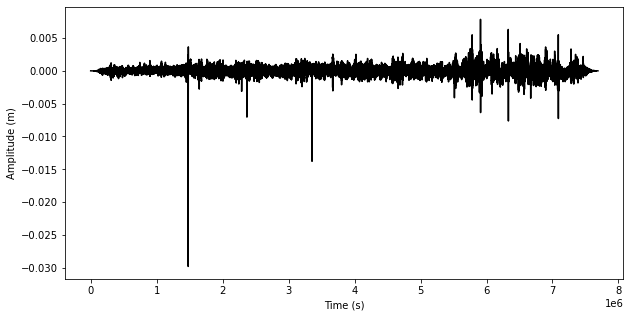

In [4]:
# plot the time series
plt.figure(figsize=(10,5))
plt.plot(Z[0].times(), Z[0].data, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (m)')

**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)
N[0].data
3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [5]:
# answer below
from scipy.signal import butter, buttord, sosfilt, sosfiltfilt, freqs
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band',output='sos')
    return sos

def butter_lowpass(low_freq_cut, fs, order=5):
    nyq = 0.5 * fs
    low = low_freq_cut / nyq
    sos = butter(order, low, btype='low', fs=fs, output='sos')
    return sos

def butter_highpass(high_freq_cut, fs, order=5):
    nyq = 0.5 * fs
    high = high_freq_cut / nyq
    sos = butter(order, high, btype='high', fs=fs, output='sos')
    return sos

In [6]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def butter_lowpass_filter(data, lowcut, fs, order=5):
    sos = butter_lowpass(lowcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def butter_highpass_filter(data, highcut, fs, order=5):
    sos = butter_highpass(highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

In [7]:
# data information
fs = Z[0].stats.sampling_rate
z=np.asarray(Z[0].data)[:-1]
t=np.arange(0.,dtime,1./fs)

# Sample rate and desired cutoff frequencies (in Hz).
lowcut = 0.01
highcut = 0.1

lowpass = 0.01
highpass = 0.1

band_filtered = butter_bandpass_filter(z, lowcut, highcut, fs, order=5)
low_filtered = butter_lowpass_filter(z, lowpass, fs, order=5)
high_filtered = butter_highpass_filter(z, highpass, fs, order=5)

# check these results against the obspy methods
# bandpass
band_filtered_obspy = Z[0].filter('bandpass', freqmin=lowcut, freqmax=highcut, corners=5)
# lowpass
low_filtered_obspy = Z[0].filter('lowpass', freq=lowpass, corners=5)
# highpass
high_filtered_obspy = Z[0].filter('highpass', freq=highpass, corners=5)

Text(0.5, 1.0, 'Highpass Filtered Time Series')

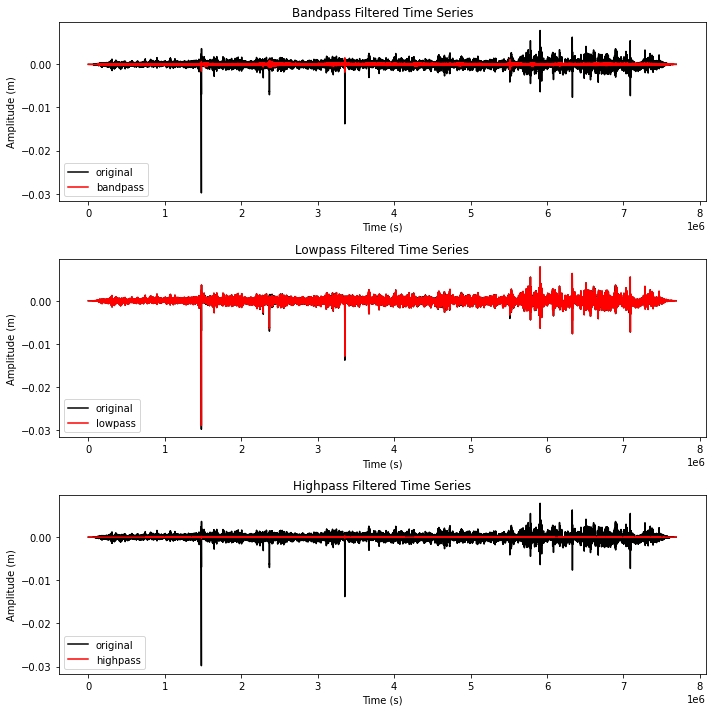

In [8]:
# plot the filtered time series and the original time series in three different subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10), tight_layout=True)
axs[0].plot(t, z, 'k', label='original')
axs[0].plot(t, band_filtered, 'r', label='bandpass')
# axs[0].plot(t, band_filtered_obspy.data, 'b', label='bandpass obspy')
axs[0].legend()
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (m)')
axs[0].set_title('Bandpass Filtered Time Series')

axs[1].plot(t, z, 'k', label='original')
axs[1].plot(t, low_filtered, 'r', label='lowpass')
# axs[1].plot(t, low_filtered_obspy.data, 'b', label='lowpass obspy')
axs[1].legend()
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude (m)')
axs[1].set_title('Lowpass Filtered Time Series')

axs[2].plot(t, z, 'k', label='original')
axs[2].plot(t, high_filtered, 'r', label='highpass')
# axs[2].plot(t, high_filtered_obspy.data, 'b', label='highpass obspy')
axs[2].legend()
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude (m)')
axs[2].set_title('Highpass Filtered Time Series')


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

In [9]:
# import FFT modules
# answer below
# compute Fourier transform of the noise time series
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = band_filtered.data.shape[0]
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(npts) # this will be an even number
freqVec = fftfreq(Nfft,)[:Nfft//2]
z_hat = fft(z,n=Nfft)
z_bandfilt_hat = fft(band_filtered.data,n=Nfft)
z_lowfilt_hat = fft(low_filtered.data,n=Nfft)
z_highfilt_hat = fft(high_filtered.data,n=Nfft)

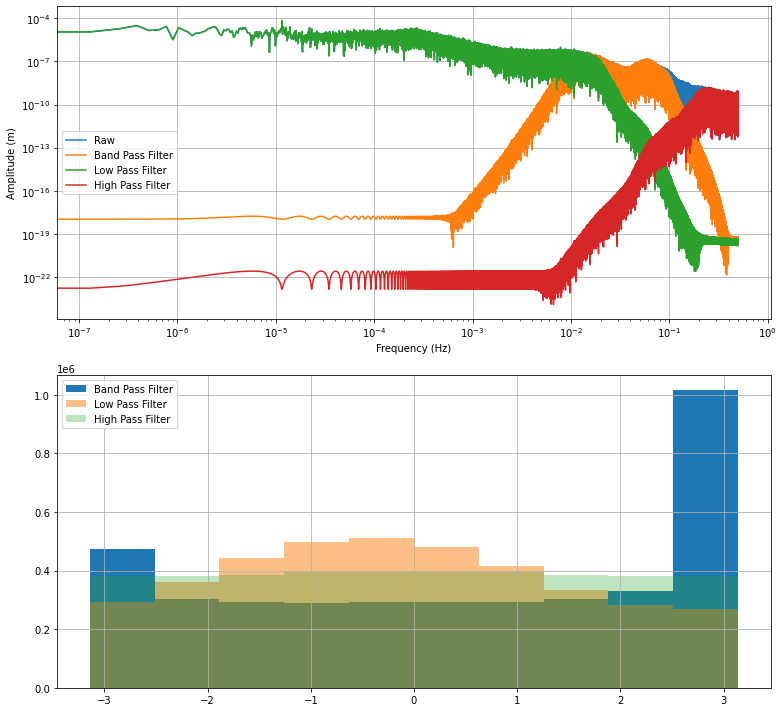

In [10]:
fig,axs=plt.subplots(2,1,figsize=(11,10), tight_layout=True)
ax=axs[0]

ax.plot(freqVec,np.abs(z_hat[:Nfft//2])/Nfft, label='Raw')
ax.plot(freqVec,np.abs(z_bandfilt_hat[:Nfft//2])/Nfft, label='Band Pass Filter')
ax.plot(freqVec,np.abs(z_lowfilt_hat[:Nfft//2])/Nfft, label='Low Pass Filter')
ax.plot(freqVec,np.abs(z_highfilt_hat[:Nfft//2])/Nfft, label='High Pass Filter')
ax.grid(True)
ax.set_xscale('log');
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('Amplitude (m)')
# ax.set_ylim(10e-13, 10e3)
ax.legend();

ax=axs[1]
ax.hist(np.angle(z_bandfilt_hat[:Nfft//2]), label='Band Pass Filter',)
ax.hist(np.angle(z_lowfilt_hat[:Nfft//2]), label='Low Pass Filter', alpha=0.5)
ax.hist(np.angle(z_highfilt_hat[:Nfft//2]), label='High Pass Filter', alpha=0.3)
ax.grid(True)
ax.legend();


Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

The relative amplitude of the bandpass filtered data is contained within the intermediate frequency signal. More generally, the amplitude decays with higher frequency. Two distinct "peaks" can be seen in the band pass filtered data aat around 0.01 (100 s) and 0.1 Hz (10 s) from the fft results above. 
At low frequencies, the amplitude signal is dominated by data within the low pass filter at lower frequencies. This changes as we move into the intermediate frequencies between 0.1 and 0.01 Hz. In this band, the band pass filtered data control the amplitude signal. 

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

c:\Users\dlhogan\anaconda3\envs\radiative_transfer\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


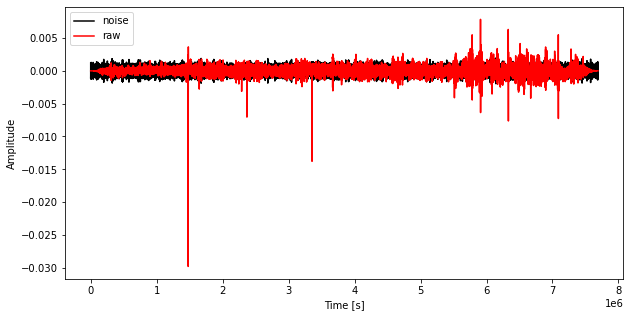

In [11]:
# answer below
from numpy import random
from scipy.fftpack import ifft,ifftshift 

# create a noise signal using the Fourier amplitude spectrum of the seismic signal with a random phase
z_hat_noise = np.abs(z_hat[:Nfft//2])*np.exp(1j*2*np.pi*random.rand(Nfft//2))
z_hat_noise = np.concatenate((z_hat_noise,z_hat_noise[::-1]))
z_hat_noise = ifftshift(z_hat_noise)
z_hat_noise = ifft(z_hat_noise)
z_hat_noise = z_hat_noise[:npts]

# plot the noise signal
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(t, z_hat_noise, 'k', label='noise')
plt.plot(t, z, 'r', label='raw')
# label the axes;
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.legend();


**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

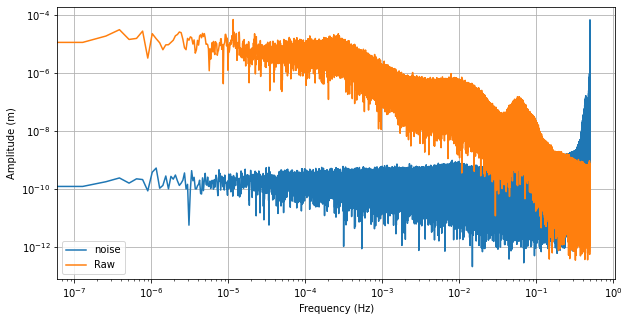

In [12]:
# answer below
# compute the Fourier transform of the noise signal
noise_fft = fft(z_hat_noise,n=Nfft)
fig, ax = plt.subplots(1,1,figsize=(10,5))
# plot the Fourier amplitude spectrum of the noise signal and the original signal
ax.plot(freqVec,np.abs(noise_fft[:Nfft//2])/Nfft, label='noise')
ax.plot(freqVec,np.abs(z_hat[:Nfft//2])/Nfft, label='Raw')
ax.grid(True)
ax.legend();
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('Amplitude (m)');
ax.set_xscale('log');
ax.set_yscale('log')


**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

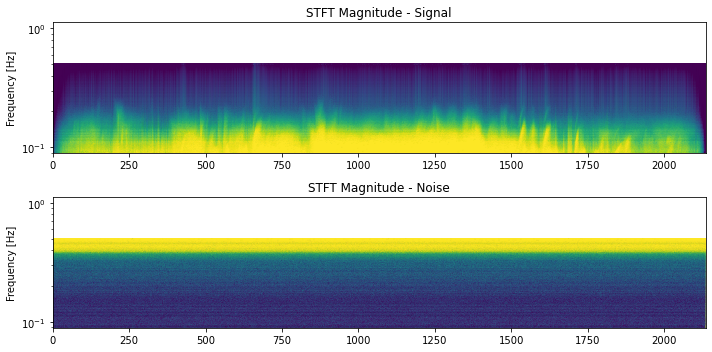

In [14]:
# answer below
from scipy.signal import stft

# compute the short-time Fourier transform
nperseg=1000
z=np.asarray(Z[0].data)
f, t, Zxx = stft(z, fs, nperseg=nperseg)
# create a figure with the mesh plot of the spectrogram
fig, axs = plt.subplots(2,1,figsize=(10,5), tight_layout=True)
ax=axs[0]
ax.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), shading='gouraud', vmin=np.mean(np.log10(np.abs(Zxx)))-np.std(np.log10(np.abs(Zxx))), vmax=np.mean(np.log10(np.abs(Zxx)))+np.std(np.log10(np.abs(Zxx))))
ax.set_title('STFT Magnitude - Signal')
ax.set_ylabel('Frequency [Hz]')
ax.set_yscale('log');
# ax.set_ylim(0.01,10)
# ax[0].set_xlabel('Time [Hours]')
ax=axs[1]
z=np.asarray(z_hat_noise.real)
f, t, Zxx = stft(z, fs, nperseg=nperseg)
# create a figure with the mesh plot of the spectrogram
ax.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), shading='gouraud', vmin=np.mean(np.log10(np.abs(Zxx)))-np.std(np.log10(np.abs(Zxx))), vmax=np.mean(np.log10(np.abs(Zxx)))+np.std(np.log10(np.abs(Zxx))))
ax.set_title('STFT Magnitude - Noise')
ax.set_ylabel('Frequency [Hz]')
ax.set_yscale('log');

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [122]:
# answer below
fn = 'ioncorr_samo_015_2022_tonga.csv'
data = pd.read_csv(fn, index_col=0)
# print the size
print(data.shape)

data.head()

(14389, 12)


,GPS_seconds,satellite_number,variometric_derived_TEC,variometric_derived_TEC_filtered,absolute_derived_TEC,absolute_derived_TEC_filtered,latitude_piercing_point,longitude_piercing_point,satellite_azimuth,satellite_elevation_angle,distance_to_piercing_point,time
0,1.326293e+09,1,0.012495,-0.006029,-0.227013,0.060790,-6.2736,-170.1929,11.46,18.17,1674.50,1.642286e+09
1,1.326293e+09,1,0.040731,0.021995,-0.190032,0.108237,-6.3212,-170.1798,11.63,18.32,1670.00,1.642286e+09
2,1.326293e+09,1,0.053964,0.040939,-0.111259,0.130265,-6.3686,-170.1670,11.79,18.46,1665.52,1.642286e+09
3,1.326293e+09,1,0.077087,0.051804,-0.061669,0.154675,-6.4159,-170.1543,11.96,18.60,1661.05,1.642286e+09
4,1.326293e+09,1,0.076847,0.069999,-0.037234,0.193697,-6.4629,-170.1419,12.12,18.75,1656.60,1.642286e+09


## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [112]:
# answer below
# get characters after ioncorr and before the next underscore
station = fn.split('_')[1]
print(station)

samo


## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

In [125]:
# convert the time column to a numpy datetime[s] object
data['datetime'] = data['time'].values.astype('datetime64[s]')

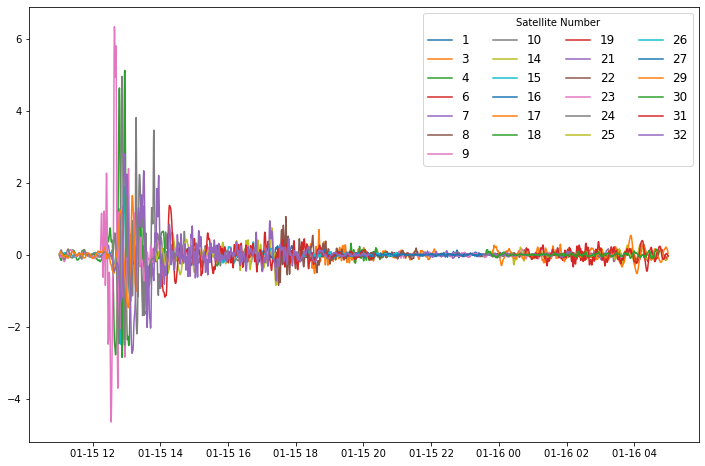

In [133]:
# answer below
# plot variometric_derived_TEC_filtered data for each satellite
fig, ax = plt.subplots(1,1,figsize=(12,8))
for sat in data['satellite_number'].unique():
    # get the data for each satellite
    data_sat = data[data['satellite_number']==sat]
    # plot the data
    ax.plot(data_sat['datetime'], data_sat['variometric_derived_TEC_filtered'], label=sat)
ax.legend(title='Satellite Number', ncol=4, fontsize=12)

You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. Select the time series of interest and plot the time series. What can you tell about the time-frequency characteristic of these disturbances?

## Tried to do this one but got lost here...

Text(0.5, 1.0, 'Morlet Wavelet')

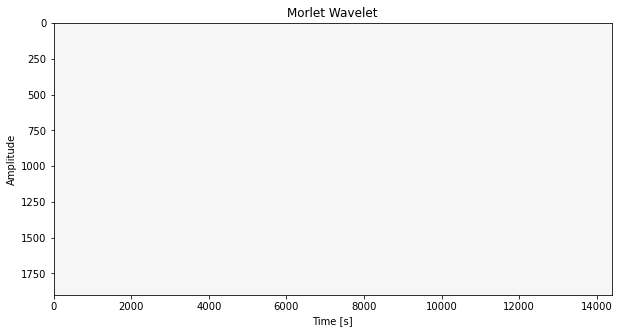

In [148]:
# answer below
# perform the wavelet transform using a Morlet transform.
from scipy.signal import morlet, cwt
# select the variometric_derived_TEC_filtered data for satellite 4
z = data['variometric_derived_TEC_filtered'].values
# apply the wavelet transform to the data
z_wavelet = cwt(z, morlet, np.arange(100,2000))
z_wavelet_yflip = np.flipud(z_wavelet)
# plot the wavelet
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(z_wavelet_yflip.real, cmap='PRGn', aspect='auto',)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Morlet Wavelet')


Calculate the sampling frequency by taking the time difference between two samples.

In [ ]:
#answer below

Perform the wavelet transform. You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

In [ ]:
import scipy.signal as signal
# use the number of scales
w = range(1,50)

# answer below


## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

(answer below)

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc``, ``NCM_SpatialGrid.nc``, and ``NCM_AuxData.nc``.

We first download the data from our Dropbox folder


In [2]:
import wget
file1 = "./data/NCM_GeologicFrameworkGrids.nc" # wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") 
# Download the coordinate grids
file2 = "./data/NCM_SpatialGrid.nc" # wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") 
# Download the coordinate grids
file3 = "./data/NCM_AuxData.nc" #wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #



In the following we will prepare our data. Read the DataSets using the python NetCDF4 library.

In [3]:
# ansert below
import netCDF4 as nc
import xarray as xr

# open the netCDF file
geology = xr.open_dataset(file1)
grid = xr.open_dataset(file2)
watertable = xr.open_dataset(file3)


**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``, which are data sets from the NC files. Use the matplotlib function``contourf``, and the variables for lat long ``x`` and ``y`` . You can use the argument ``levels`` to the contourf funxtion to split the color map into discrete contour levels, and the transparency argument ``alpha`` to be less than 1.

In [4]:
# answer below
### WHERE is the metadata?????????
# print the size of the Longitude vector
print(grid['Longitude vector'].shape)
# print the size of the Latitude vector
print(grid['Latitude vector'].shape)
# print the shape of Water Table Depth
print(watertable['Water Table Depth'].shape)
# print the shape of the Surface Elevation vector
print(geology['Surface Elevation'].shape)

(662,)
(311,)
(4901, 3201)
(4901, 3201)


Text(0, 0.5, 'Latitude [deg]')

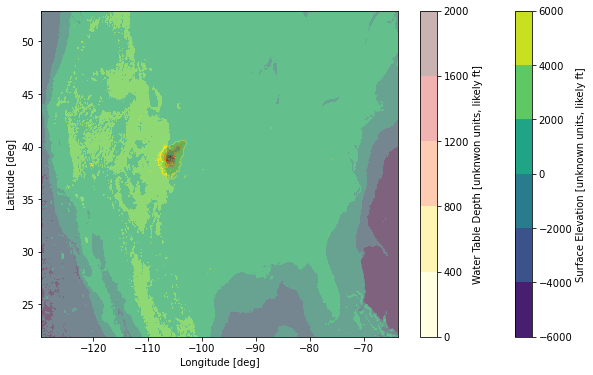

In [5]:
# plot the surface elevation contours
plt.figure(figsize=(10,6))
# recreate the lat long vectors.
minlat,maxlat = min(grid['Latitude vector'][:]),max(grid['Latitude vector'][:])
minlon,maxlon = min(grid['Longitude vector'][:]),max(grid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)
plt.contourf(xlon, xlat, geology['Surface Elevation'].T, levels=5,)
# adda colorbar
plt.colorbar(label='Surface Elevation [unknown units, likely ft]')
# plot the water table depth contours

plt.contourf(xlon, xlat, watertable['Water Table Depth'].T,alpha=0.3, levels=5,
             # use a white to dark colormap
             cmap='hot_r')
# add a colorbar
plt.colorbar(label='Water Table Depth [unknwon units, likely ft]')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')


### These data have no metadata so I do not know what any of the units are...

**b. Perform and plot the 2D Fourier transforms (4 points)**

this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


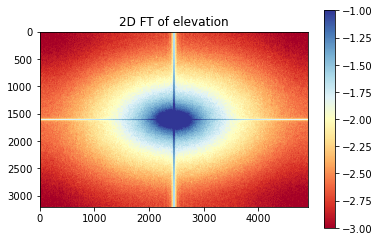

In [6]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift
import matplotlib.cm as cm
Zel = fft2(geology['Surface Elevation'].T.values)
# make a vector of distances. Here I will ignore the curvature and spatial projection.
# make the wavenumber frequency vector: 
Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))


Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

# amplitude of the DEM
plt.imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu')
plt.title('2D FT of elevation')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.colorbar()
plt.show()

### For this analysis I used code from [this resource](https://github.com/bpurinton/DEM-FFT/blob/master/example_analysis.ipynb) which explains how to analysis a 2D DEM with an FFT

In [7]:
# get the size of the raster and save a copy of the original grid
z = geology['Surface Elevation'].T.values
z_original = geology['Surface Elevation'].T.values
ny, nx = geology['Surface Elevation'].T.values.shape

# use linear algebra to fit a plane by least squares
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

# apply hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

In [8]:
# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# # index of zero frequency (DC component)
xc, yc = (Lx//2, Ly//2)

# # zero out the DC component
fft_shift[yc, xc] = 0

# get the DFT periodogram with units of m^2 for topography
# include weights of hann to correct for windowing
p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# The periodogram is a measure of how much of the
# original elevation field's variance falls within a given frequency range.
# You can check that the sum of the periodogram is roughly equal to the
# variance in Z. (The variance will be somewhat less due to the zero padding.)

# calculate radial frequencies
# xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

# wavenumbers
kx = x - xc
ky = y - yc
# kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

# radial frequencies
fx = kx / (Lx * drlon)
fy = ky / (Ly * drlat)
f2d = np.sqrt(fx**2 + fy**2)
# w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
# f2d = 1/w2d

# fourier angles
F_ang2d = np.rad2deg(np.arctan2(ky*drlat, kx*drlon))

# Create sorted, non-redundant vectors of frequency and power
p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
f1d = f2d[:, 0:xc+1].copy() # same for the frequency
F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

# set reundant columns to negative for clipping below
f1d[yc:Ly, xc] = -1

# concatenate frequency and power and sort by frequency
f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
I = np.argsort(f1d[:, 0])
f1d = f1d[I, :]

# remove negative values
f1d = f1d[f1d[:, 0] > 0, :]

# extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
F_ang1d = f1d[:, 2]
f1d = f1d[:, 0]

In [9]:
# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))

C:\Users\dlhogan\AppData\Local\Temp/ipykernel_20796/3964471229.py:5: RuntimeWarning: divide by zero encountered in power
  p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))


C:\Users\dlhogan\AppData\Local\Temp/ipykernel_20796/2920188142.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax.get_xticks()])


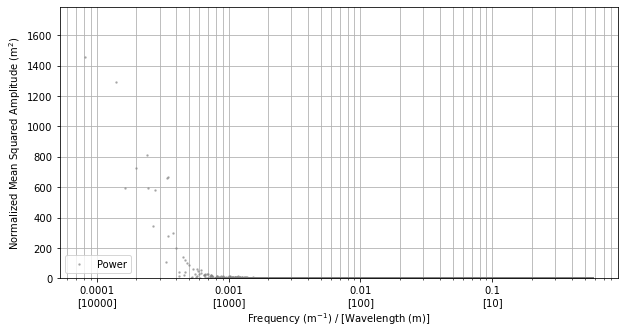

In [10]:
# then plot the normalized 1D power specturm
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.semilogx(f1d[::2], p1d_norm[::2], '.', c='gray', alpha=0.5, markersize=3, label="Power",
          rasterized=True)
ax.set_ylim(0, p1d_norm.max())
ax.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax.get_xticks()])
ax.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax.grid(True, which="both")
ax.legend(loc='lower left', fontsize=10)
ax.set_title('Elevation Normalized mean 1D power spectrum')

C:\Users\dlhogan\AppData\Local\Temp/ipykernel_9696/4205924658.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
C:\Users\dlhogan\AppData\Local\Temp/ipykernel_9696/4205924658.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.plot_surface(kx, ky, np.log10(p2d_norm), cmap=cm.coolwarm,


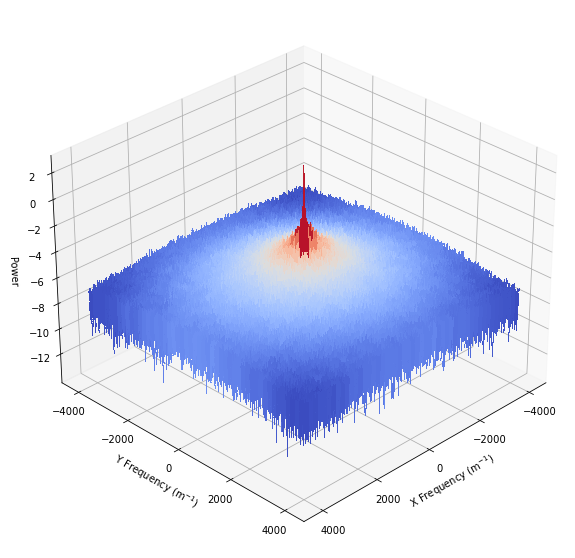

In [66]:
# plot in 3d and make it interactive
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(kx, ky, np.log10(p2d_norm), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("X Frequency (m$^{-1}$)")
ax.set_ylabel("Y Frequency (m$^{-1}$)")
ax.set_zlabel("Power")
ax.view_init(30, 45)
plt.show()


this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


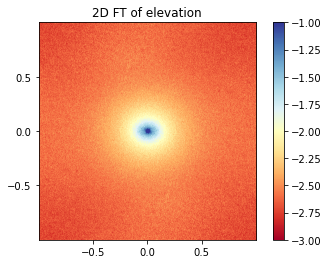

In [42]:
Zwt = fft2(watertable['Water Table Depth'].T.values)
# make a vector of distances. Here I will ignore the curvature and spatial projection.
# make the wavenumber frequency vector: 
Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))


Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

# amplitude of the DEM
plt.imshow(fftshift(np.log10(np.abs(Zwt)/Zwt.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
plt.title('2D FT of water table depth')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.xticks([-0.5,0,0.5])
plt.yticks([-0.5,0,0.5])
plt.colorbar()
plt.show()

C:\Users\dlhogan\AppData\Local\Temp/ipykernel_9696/3285896329.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


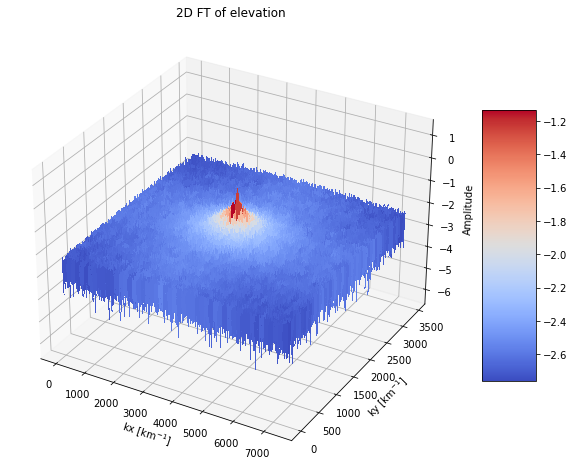

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
# Make data.
X = Rlon
Y = Rlat
X, Y = np.meshgrid(X, Y)
Z = fftshift(np.log10(np.abs(Zwt)/Zwt.size))
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('kx [km$^{-1}$]')
ax.set_ylabel('ky [km$^{-1}$]')
ax.set_zlabel('Amplitude')
ax.set_title('2D FT of water table depth')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### For this analysis I used code from [this resource](https://github.com/bpurinton/DEM-FFT/blob/master/example_analysis.ipynb) which explains how to analysis a 2D DEM with an FFT

In [85]:
# get the size of the raster and save a copy of the original grid
z = watertable['Water Table Depth'].T.values
z_original = watertable['Water Table Depth'].T.values
ny, nx = watertable['Water Table Depth'].T.values.shape

# use linear algebra to fit a plane by least squares
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

# apply hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

In [86]:
# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# # index of zero frequency (DC component)
xc, yc = (Lx//2, Ly//2)

# # zero out the DC component
fft_shift[yc, xc] = 0

# get the DFT periodogram with units of m^2 for topography
# include weights of hann to correct for windowing
p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# The periodogram is a measure of how much of the
# original elevation field's variance falls within a given frequency range.
# You can check that the sum of the periodogram is roughly equal to the
# variance in Z. (The variance will be somewhat less due to the zero padding.)

# calculate radial frequencies
# xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

# wavenumbers
kx = x - xc
ky = y - yc
# kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

# radial frequencies
fx = kx / (Lx * drlon)
fy = ky / (Ly * drlat)
f2d = np.sqrt(fx**2 + fy**2)
# w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
# f2d = 1/w2d

# fourier angles
F_ang2d = np.rad2deg(np.arctan2(ky*drlat, kx*drlon))

# Create sorted, non-redundant vectors of frequency and power
p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
f1d = f2d[:, 0:xc+1].copy() # same for the frequency
F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

# set reundant columns to negative for clipping below
f1d[yc:Ly, xc] = -1

# concatenate frequency and power and sort by frequency
f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
I = np.argsort(f1d[:, 0])
f1d = f1d[I, :]

# remove negative values
f1d = f1d[f1d[:, 0] > 0, :]

# extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
F_ang1d = f1d[:, 2]
f1d = f1d[:, 0]

In [87]:
# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))

C:\Users\dlhogan\AppData\Local\Temp/ipykernel_9696/3964471229.py:5: RuntimeWarning:

divide by zero encountered in power



C:\Users\dlhogan\AppData\Local\Temp/ipykernel_9696/2736551379.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



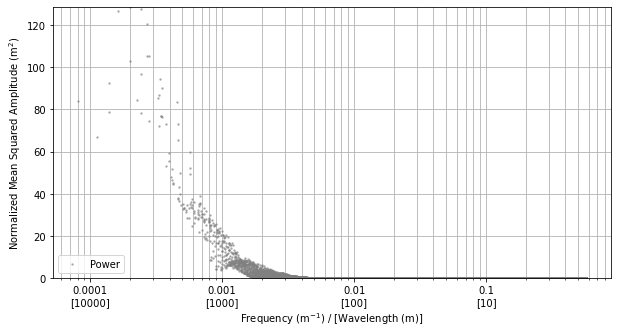

In [88]:
# then plot the normalized 1D power specturm
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.semilogx(f1d[::1], p1d_norm[::1], '.', c='gray', alpha=0.5, markersize=3, label="Power",
          rasterized=True)
ax.set_ylim(0, p1d_norm.max())
ax.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax.get_xticks()])
ax.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax.grid(True, which="both")
ax.legend(loc='lower left', fontsize=10)
ax.set_title('Water Table Depth Normalized mean 1D power spectrum')

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

The wavelengths that dominate both the DEM and the water table are right around 1000 meters. This makes sense because the spatial resolution of this dataset is around 1 kilometer. At shorter wavelengths (higher frequencies), larger scale signals are lost since the data cannot resolve finer resolution signals well. There are some longer wavelengths on the scale of 10s of kilometers that are likely local features resolved within the DEM (coast lines, mountain ranges, etc.)

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

In [11]:
# got help from this resource: https://stackoverflow.com/questions/58412102/how-to-implement-a-butterworth-filter-over-a-2d-np-array-of-a-medical-image-in-p


from scipy.signal import filtfilt


def butterLow(cutoff, critical, order):
    normal_cutoff = float(cutoff) / critical
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butterFilter(data, cutoff_freq, nyq_freq, order):
    b, a = butterLow(cutoff_freq, nyq_freq, order)
    y = filtfilt(b, a, data)
    return y



Here are some examples of some different filters that can be applied to the DEM. We see that a filtering frequency of around 0.001 m-1 (which is where the peak frequency is in the spatial domain), provides a good amount of information. This makes sense because the dem spatial resolution is around 1 km (or 1000 meters), so I am not surprised that applying a low pass filter below this value loses a lot of information. 

DEM Filter
Water Table Filter


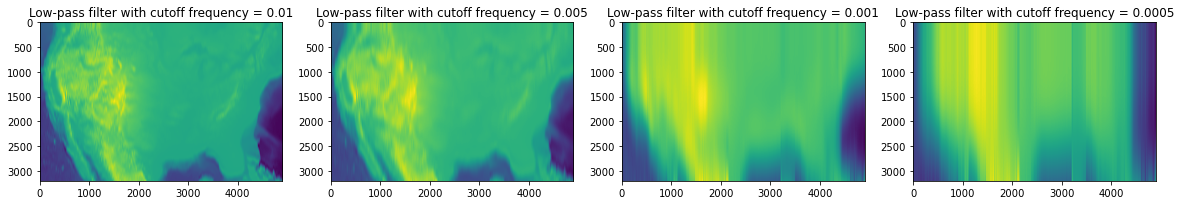

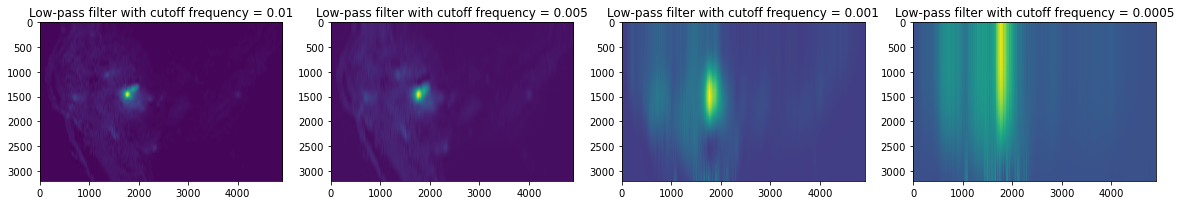

In [51]:
# apply the filter
cutoff_freq = [0.01, 0.005, 0.001, 0.0005]
sample_rate = drlon
z = geology['Surface Elevation'].values
# compare different cutoff frequencies in plots
print('DEM Filter')
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i,freq in enumerate(cutoff_freq):
    y = butterFilter(z, freq, sample_rate/2, order=5)
    axs[i].imshow(y.T[::-1], cmap='viridis')
    axs[i].set_title('Low-pass filter with cutoff frequency = ' + str(freq))

cutoff_freq = [0.01, 0.005, 0.001, 0.0005]
sample_rate = drlon
z = watertable['Water Table Depth'].values
print('Water Table Filter')
# compare different cutoff frequencies in plots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i,freq in enumerate(cutoff_freq):
    y = butterFilter(z, freq, sample_rate/2, order=5)
    axs[i].imshow(y.T[::-1], cmap='viridis')
    axs[i].set_title('Low-pass filter with cutoff frequency = ' + str(freq))

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [43]:
# Sort the Fourier coefficients
Zelsort = np.sort(np.abs(np.abs(Zel).reshape(-1)))
Zwtsort = np.sort(np.abs(np.abs(Zwt).reshape(-1)))

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

We are keeping up to 0.100000 the number of Fourier coefficients
We are keeping up to 0.050000 the number of Fourier coefficients
We are keeping up to 0.010000 the number of Fourier coefficients


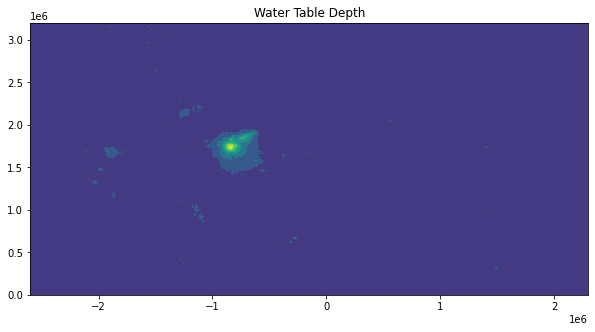

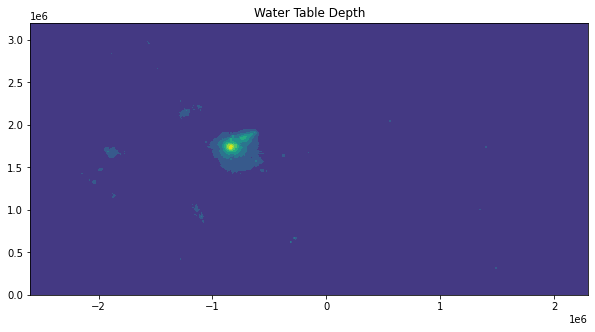

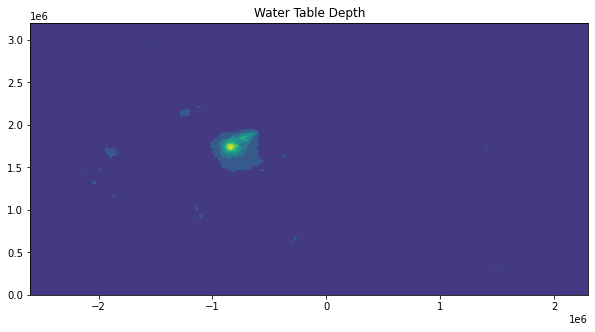

In [47]:

#snwer below
from IPython import display
import time
from scipy.fftpack import ifft2

# create a grid of latitude and longitude
x = grid['x'][0:4901, 0:3201]
y = grid['y'][0:4901, 0:3201]
for keep in (0.1,0.05, 0.01):
    # create figure
    fig, ax = plt.subplots(1,1,figsize=(10,5))

    thresh = Zwtsort[int(np.floor( (1-keep)*len(Zwtsort) ))]
    ind = np.abs(Zwt)>thresh
    Atlow = Zwt * ind # here we zero out the matrix
    # Here we count the number of non-zeros in the matrix
    print("We are keeping up to %f the number of Fourier coefficients" % keep)
    Alow = ifft2(Atlow).real
    ax.contourf(x, y, Alow.T)
    ax.set_title('Water Table Depth')
    time.sleep(1)

It appears very little information is lost here, likely since a lot of the signal does not provide much useful information.

Now we will compare the original 2D data set with the Fourier compressed data


We are keeping up to 0.010000 the number of Fourier coefficients


(-129.72398376464844,
 -63.623985290527344,
 21.92206382751465,
 52.92206573486328)

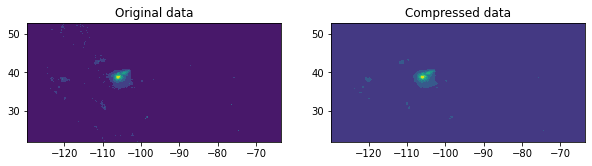

In [46]:
# answer below
keep=0.01
thresh = Zwtsort[int(np.floor( (1-keep)*len(Zwtsort) ))]
ind = np.abs(Zwt)>thresh
Atlow = Zwt * ind # here we zero out the matrix
# Here we count the number of non-zeros in the matrix
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real


fig,ax=plt.subplots(1,2,figsize=(10,20),sharex=True)
ax[0].contourf(xlon, xlat, watertable['Water Table Depth'].T.values);
ax[0].set_title('Original data')
ax[0].axis('scaled')

ax[1].contourf(xlon, xlat, Alow);
ax[1].set_title('Compressed data')
ax[1].axis('scaled')